In [5]:
import pandas as pd
from xgboost import plot_importance, plot_tree
import matplotlib

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import xgboost as xgb

path = "/home/ichida/dev_env/ml/data/zara_challenge/zara_data_go_2019_all_dataset"

sales_stock_df = pd.read_csv(f"{path}/sales_stock.csv")
products_df = pd.read_csv(f"{path}/products.csv")
positions_df = pd.read_csv(f"{path}/positions.csv")

### Prepare Data

In [6]:
position_features = positions_df.groupby(['date_number', 'product_id']).agg({'position':['max', 'mean', 'min']}).reset_index()
position_features.columns = ['date_number', 'product_id', 'max_position', 'mean_position', 'position']

In [7]:
product_sales_stock = pd.merge(products_df, sales_stock_df, on='product_id')
groupby_columns = ['product_id', 'family_id', 'subfamily_id', 'price', 'date_number', 'color_id', 'size_id']
product_sales_stock = product_sales_stock.groupby(groupby_columns).agg({'sales':'sum', 'stock':'sum'}).reset_index()

### Feature selection

In [8]:
all_features = pd.merge(product_sales_stock, position_features, on=['date_number', 'product_id'])
all_features.loc[:, 'product_id'] = all_features.loc[:, 'product_id'].astype('category')
all_features.loc[:, 'family_id'] = all_features.loc[:, 'family_id'].astype('category')
all_features.loc[:, 'size_id'] = all_features.loc[:, 'size_id'].astype('category')
all_features.loc[:, 'color_id'] = all_features.loc[:, 'color_id'].astype('category')
all_features = all_features.drop(columns=['product_id', 'subfamily_id'], axis=1)
all_features.columns

Index(['family_id', 'price', 'date_number', 'color_id', 'size_id', 'sales',
       'stock', 'max_position', 'mean_position', 'position'],
      dtype='object')

In [9]:
all_features.select_dtypes(np.number).columns

Index(['price', 'date_number', 'sales', 'stock', 'max_position',
       'mean_position', 'position'],
      dtype='object')

In [19]:
test_values = all_features[all_features['date_number'] > 85]
val_values = all_features[(all_features['date_number'] > 79)&(all_features['date_number'] <= 85)]
train_features = all_features[all_features['date_number'] <=79]

### Prepare and train the models

In [20]:

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number))
        ])),  
        # Categorical features
        ('categoricals', Pipeline([
            ('selector', TypeSelector('category')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]))  
    ])), 
    ('clf', xgb.XGBRegressor(objective="reg:linear", booster="gbtree", nthread=3))
])  


 ### Hyperparemeter tuning

In [ ]:
param_grid = {
    'clf__max_depth': np.arange(3, 6, 1)
}

randomized_mse = RandomizedSearchCV(param_distributions=param_grid, estimator=transformer, n_iter=2, 
                                    scoring="neg_mean_squared_error", verbose=1, cv=3)

x, y = train_features.drop(columns=['sales', 'date_number'], axis=1), train_features['sales']
randomized_mse.fit(x, y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[17:20:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1584539733809/work/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [17]:
print(randomized_mse.best_score_)
print(randomized_mse.best_estimator_)

-4.178330764794235
Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=1,
                              transformer_list=[('numericals',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  TypeSelector(dtype=<class 'numpy.number'>))],
                                                          verbose=False)),
                                                ('categoricals',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  TypeSelector(dtype='category')),
                                                                 ('encoder',
                                                                  OneHotEncoder(categories='auto',
  

In [18]:
x_test, y_test = test_values.drop(columns=['sales', 'date_number'], axis=1), test_values['sales']
preds_test = randomized_mse.best_estimator_.predict(x_test)
mean_squared_error(y_test.values, preds_test)

4.342640285503186

In [19]:
df_test = x_test.copy()
df_test.loc[:, 'predicted_sales'] = preds_test
df_test.loc[:, 'sales'] = y_test
df_test.loc[:, 'residual'] = df_test.loc[:, 'predicted_sales'] - df_test.loc[:, 'sales'] 
df_test[df_test['sales']>40][['sales','predicted_sales', 'residual']]

,sales,predicted_sales,residual
155617,50,5.101900,-44.898100
155620,53,2.117723,-50.882277
155625,85,1.629269,-83.370731
155629,46,5.414535,-40.585465
155634,44,6.189514,-37.810486
...,...,...,...
2897137,59,8.612854,-50.387146
2897139,45,10.197991,-34.802009
2945701,47,2.076533,-44.923467
2945705,42,2.127935,-39.872065


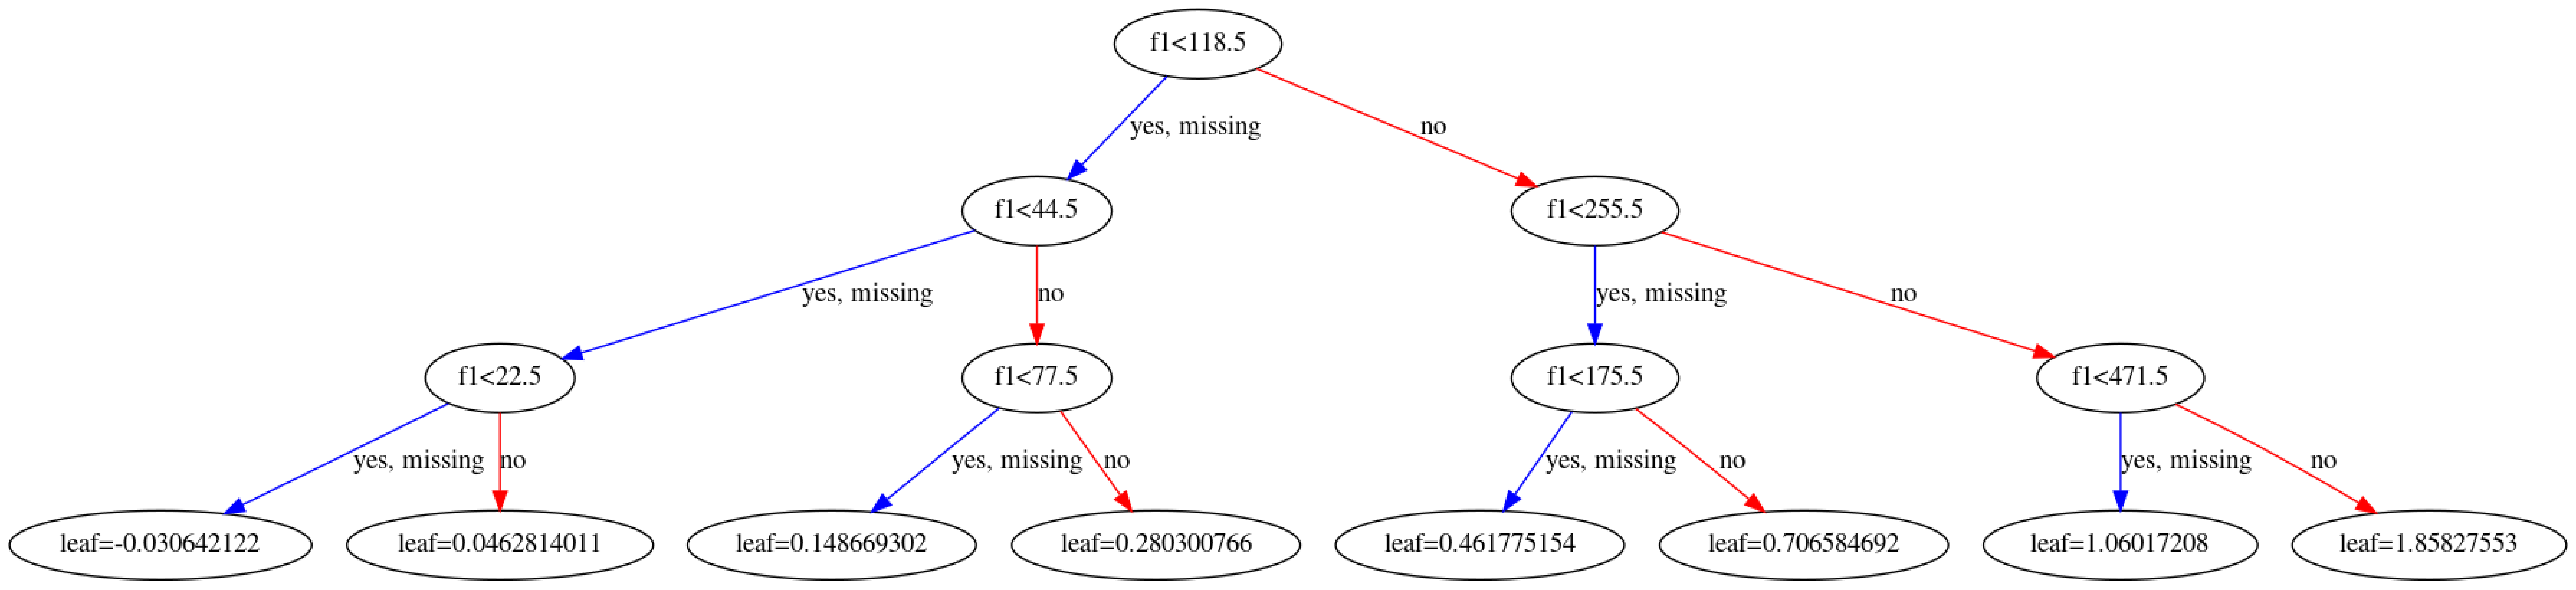

In [22]:
plot_tree(randomized_mse.best_estimator_.named_steps['clf'])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [23]:
best = randomized_mse.best_estimator_